<a href="https://colab.research.google.com/github/trungdung1711/credit_card_fraud_detection/blob/feature%2Freimplementation/notebooks/_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CREDIT CARD FRAUD DETECTION

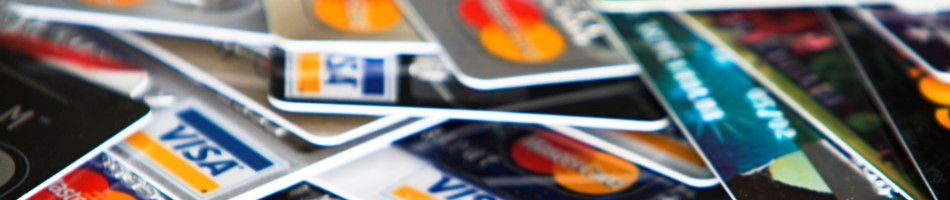

## DATASET FROM https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

## DATASET DOWNLOADING

## EXPLORATORY DATA

## MODEL TRANINING

## MODEL EVALUATION

In [ ]:

# ==============================================================
# 1. Import thư viện
# ==============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE

# ==============================================================
# 2. Đọc dữ liệu và hiển thị thông tin dữ liệu
# ==============================================================
df = pd.read_csv("/content/sample_data/creditcard.csv")
# df = pd.read_csv("creditcard.csv")

print(df.head())
print(df.info())
print("\nTỷ lệ lớp (Class):")
print(df["Class"].value_counts(normalize=True))
print( df.describe())

# ==============================================================
# 3. Vẽ ma trận tương quan giữa các thuộc tính
# ==============================================================
# Tạo thư mục lưu hình ảnh
os.makedirs("figures", exist_ok=True)

plt.figure(figsize=(12,10))
corr = df.corr()

sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Ma trận tương quan giữa các thuộc tính")
plt.tight_layout()
plt.savefig("figures/correlation_matrix.png", dpi=150)
plt.close()

# ==============================================================
# 4. Chuẩn bị dữ liệu
# ==============================================================
X = df.drop(columns=["Class", "Time"])
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ==============================================================
# 5. Áp dụng SMOTE để cân bằng dữ liệu cho việc đánh giá trên tập test
# ==============================================================
# Chuẩn hóa cột Amount, Comment lại khi đánh giá mô hình
# scaler = StandardScaler()
# X_train["Amount"] = scaler.fit_transform(X_train[["Amount"]])
# X_test["Amount"] = scaler.transform(X_test[["Amount"]])

# smote = SMOTE(sampling_strategy=0.2, random_state=42)
# X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# print("\nPhân phối lớp trước và sau SMOTE:")
# print("Trước SMOTE:", np.bincount(y_train))
# print("Sau SMOTE:", np.bincount(y_train_res))

# ==============================================================
# 6. Vẽ phân phối của từng feature theo Class và sau SMOTE
# ==============================================================
# features = [c for c in df.columns if c not in ["Class", "Time"]]

# # Tạo DataFrame sau SMOTE để trực quan
# X_smote_df = pd.DataFrame(X_train_res, columns=X.columns)
# X_smote_df["Class"] = y_train_res.values

# for col in features:
#     plt.figure(figsize=(6, 4))
#     # Phân phối gốc
#     sns.kdeplot(data=df[df["Class"] == 0], x=col, label="Class 0 (gốc)", fill=True, alpha=0.4)
#     sns.kdeplot(data=df[df["Class"] == 1], x=col, label="Class 1 (gốc)", fill=True, alpha=0.4, color="r")

#     # Phân phối sau SMOTE
#     sns.kdeplot(
#     data=X_smote_df[X_smote_df["Class"] == 1],
#     x=col, label="Class 1 (sau SMOTE)", fill=False, color="green", linestyle="--"
#     )

#     plt.title(f"Phân phối đặc trưng {col}\n(Class 0, Class 1 gốc, Class 1 sau SMOTE)")
#     plt.legend()
#     plt.tight_layout()
#     plt.savefig(f"figures/feature_distribution_{col}_with_smote.png", dpi=150)
#     plt.close()

# ==============================================================
# 7. Hàm đánh giá mô hình bằng K-Fold (trả về trung bình các metrics)
# ==============================================================

def evaluate_model_kfold(model, params, X, y, model_name, k=5):
    print(f"\n===== Đang đánh giá {model_name} với {params} không smote =====")

    # Thiết lập tham số mô hình
    model.set_params(**params)

    # K-fold chia dữ liệu
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    # Danh sách lưu metric
    precisions, recalls, f1s, aucs = [], [], [], []
    start_time = time.time()

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
        y_train, y_val = y.iloc[train_idx].copy(), y.iloc[val_idx].copy()

        # Chuẩn hóa dữ liệu
        scaler = StandardScaler()
        X_train['Amount'] = scaler.fit_transform(X_train[['Amount']])
        X_val['Amount'] = scaler.transform(X_val[['Amount']])

        # Train
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        y_prob = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else None

        # Đánh giá từng fold
        precisions.append(precision_score(y_val, y_pred))
        recalls.append(recall_score(y_val, y_pred))
        f1s.append(f1_score(y_val, y_pred))
        if y_prob is not None:
            aucs.append(roc_auc_score(y_val, y_prob))

        print(f"Fold {fold}/{k} done.")

    end_time = time.time()
    duration = end_time - start_time

    # Trả về kết quả trung bình
    return {
        "Model": model_name,
        "Precision": np.mean(precisions),
        "Recall": np.mean(recalls),
        "F1-Score": np.mean(f1s),
        "Training Time": duration,
        "ROC-AUC": np.mean(aucs) if aucs else np.nan
    }


def evaluate_model_kfold_smote(model, params, X, y, model_name, k=5):
    print(f"\n===== Đang đánh giá {model_name} với {params} có smote =====")

    # Thiết lập tham số mô hình
    model.set_params(**params)

    # K-fold chia dữ liệu
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    smote = SMOTE(sampling_strategy=0.2, random_state=42)

    # Danh sách lưu metric
    precisions, recalls, f1s, aucs = [], [], [], []
    start_time = time.time()

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
        y_train, y_val = y.iloc[train_idx].copy(), y.iloc[val_idx].copy()

        # Chuẩn hóa dữ liệu
        scaler = StandardScaler()
        X_train['Amount'] = scaler.fit_transform(X_train[['Amount']])
        X_val['Amount'] = scaler.transform(X_val[['Amount']])

        # Cân bằng dữ liệu bằng SMOTE
        X_res, y_res = smote.fit_resample(X_train, y_train)

        # Train
        model.fit(X_res, y_res)
        y_pred = model.predict(X_val)
        y_prob = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else None

        # Đánh giá từng fold
        precisions.append(precision_score(y_val, y_pred))
        recalls.append(recall_score(y_val, y_pred))
        f1s.append(f1_score(y_val, y_pred))
        if y_prob is not None:
            aucs.append(roc_auc_score(y_val, y_prob))

        print(f"Fold {fold}/{k} done.")

    end_time = time.time()
    duration = end_time - start_time

    # Trả về kết quả trung bình
    return {
        "Model": model_name,
        "Precision": np.mean(precisions),
        "Recall": np.mean(recalls),
        "F1-Score": np.mean(f1s),
        "Training Time": duration,
        "ROC-AUC": np.mean(aucs) if aucs else np.nan
    }


# ==============================================================
# 8. Danh sách mô hình và bộ tham số cần thử nghiệm
# ==============================================================
model_configs = [
    # Logistic Regression
    (
        LogisticRegression(random_state=42, max_iter=1000),
        [
            {},
            {"class_weight": "balanced"},
        ]
    ),

    # Random Forest
    (
        RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            n_jobs=-1
        ),
        [
            {},
            {"class_weight": "balanced"},
        ]
    ),

    # SVC
    (
        SVC(probability=True, random_state=42),
        [
            {"kernel": "rbf"},
            {"kernel": "poly"},
            {"kernel": "linear"},
            {"class_weight": "balanced", "kernel": "poly"},
        ]
    )
]


# ==============================================================
# 9. Chạy đánh giá
# ==============================================================
results = []
for model, param_list in model_configs:
    for params in param_list:
        model_name = repr(model)
        result = evaluate_model_kfold(model, params, X_train, y_train, model_name, k=4)
        # result = evaluate_model_kfold_smote(model, params, X_train, y_train, model_name, k=4)
        results.append(result)

results_df = pd.DataFrame(results)
results_df.sort_values(by="F1-Score", ascending=False, inplace=True)

print("\n===== KẾT QUẢ TỔNG HỢP =====")
print(results_df)
# ======= Xuất ra file CSV =======
results_df.to_csv("figures/results.csv", index=False, encoding="utf-8-sig")

# ==============================================================
# 10. Huấn luyện mô hình chạy trên tập test
# ==============================================================
# model = RandomForestClassifier(
#     n_estimators=200,
#     random_state=42,
#     n_jobs=-1,
#     # class_weight="balanced_subsample"
# )
# model = SVC(probability=True, random_state=42, kernel="rbf")
# # No SMOTE
# model.fit(X_train, y_train)
# # SMOTE
# # model.fit(X_train_res, y_train_res)
#
# Dự đoán
# y_pred = model.predict(X_test)
# y_prob = model.predict_proba(X_test)[:, 1]

# # Đánh giá
# # Tạo confusion matrix
# cm = confusion_matrix(y_test, y_pred)
# labels = ["Class 0 (Normal)", "Class 1 (Fraud)"]

# # Vẽ biểu đồ heatmap
# plt.figure(figsize=(5,4))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
# plt.title("Confusion Matrix")
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.tight_layout()
# plt.savefig("figures/confusion_matrix.png", dpi=150)

# print("\nConfusion Matrix:\n", cm)
# print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
# print("ROC-AUC:", roc_auc_score(y_test, y_prob))

# # ==============================================================
# # 8. Vẽ feature importance
# # ==============================================================
# importances = model.feature_importances_
# feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
# plt.figure(figsize=(8,6))
# sns.barplot(x=feat_imp[:], y=feat_imp.index[:])
# plt.title("Top 10 Feature Importance (RandomForest)")
# plt.tight_layout()
# plt.savefig("figures/feature_importance.png", dpi=150)
# plt.close()



   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [ ]:

# ==============================================================
# 1. Import thư viện
# ==============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE

# ==============================================================
# 2. Đọc dữ liệu và hiển thị thông tin dữ liệu
# ==============================================================
df = pd.read_csv("/content/sample_data/creditcard.csv")
# df = pd.read_csv("creditcard.csv")

print(df.head())
print(df.info())
print("\nTỷ lệ lớp (Class):")
print(df["Class"].value_counts(normalize=True))
print( df.describe())

# ==============================================================
# 3. Vẽ ma trận tương quan giữa các thuộc tính
# ==============================================================
# Tạo thư mục lưu hình ảnh
os.makedirs("figures", exist_ok=True)

plt.figure(figsize=(12,10))
corr = df.corr()

sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Ma trận tương quan giữa các thuộc tính")
plt.tight_layout()
plt.savefig("figures/correlation_matrix.png", dpi=150)
plt.close()

# ==============================================================
# 4. Chuẩn bị dữ liệu
# ==============================================================
X = df.drop(columns=["Class", "Time"])
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ==============================================================
# 5. Áp dụng SMOTE để cân bằng dữ liệu cho việc đánh giá trên tập test
# ==============================================================
# Chuẩn hóa cột Amount, Comment lại khi đánh giá mô hình
# scaler = StandardScaler()
# X_train["Amount"] = scaler.fit_transform(X_train[["Amount"]])
# X_test["Amount"] = scaler.transform(X_test[["Amount"]])

# smote = SMOTE(sampling_strategy=0.2, random_state=42)
# X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# print("\nPhân phối lớp trước và sau SMOTE:")
# print("Trước SMOTE:", np.bincount(y_train))
# print("Sau SMOTE:", np.bincount(y_train_res))

# ==============================================================
# 6. Vẽ phân phối của từng feature theo Class và sau SMOTE
# ==============================================================
# features = [c for c in df.columns if c not in ["Class", "Time"]]

# # Tạo DataFrame sau SMOTE để trực quan
# X_smote_df = pd.DataFrame(X_train_res, columns=X.columns)
# X_smote_df["Class"] = y_train_res.values

# for col in features:
#     plt.figure(figsize=(6, 4))
#     # Phân phối gốc
#     sns.kdeplot(data=df[df["Class"] == 0], x=col, label="Class 0 (gốc)", fill=True, alpha=0.4)
#     sns.kdeplot(data=df[df["Class"] == 1], x=col, label="Class 1 (gốc)", fill=True, alpha=0.4, color="r")

#     # Phân phối sau SMOTE
#     sns.kdeplot(
#     data=X_smote_df[X_smote_df["Class"] == 1],
#     x=col, label="Class 1 (sau SMOTE)", fill=False, color="green", linestyle="--"
#     )

#     plt.title(f"Phân phối đặc trưng {col}\n(Class 0, Class 1 gốc, Class 1 sau SMOTE)")
#     plt.legend()
#     plt.tight_layout()
#     plt.savefig(f"figures/feature_distribution_{col}_with_smote.png", dpi=150)
#     plt.close()

# ==============================================================
# 7. Hàm đánh giá mô hình bằng K-Fold (trả về trung bình các metrics)
# ==============================================================

def evaluate_model_kfold(model, params, X, y, model_name, k=5):
    print(f"\n===== Đang đánh giá {model_name} với {params} không smote =====")

    # Thiết lập tham số mô hình
    model.set_params(**params)

    # K-fold chia dữ liệu
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    # Danh sách lưu metric
    precisions, recalls, f1s, aucs = [], [], [], []
    start_time = time.time()

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
        y_train, y_val = y.iloc[train_idx].copy(), y.iloc[val_idx].copy()

        # Chuẩn hóa dữ liệu
        scaler = StandardScaler()
        X_train['Amount'] = scaler.fit_transform(X_train[['Amount']])
        X_val['Amount'] = scaler.transform(X_val[['Amount']])

        # Train
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        y_prob = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else None

        # Đánh giá từng fold
        precisions.append(precision_score(y_val, y_pred))
        recalls.append(recall_score(y_val, y_pred))
        f1s.append(f1_score(y_val, y_pred))
        if y_prob is not None:
            aucs.append(roc_auc_score(y_val, y_prob))

        print(f"Fold {fold}/{k} done.")

    end_time = time.time()
    duration = end_time - start_time

    # Trả về kết quả trung bình
    return {
        "Model": model_name,
        "Precision": np.mean(precisions),
        "Recall": np.mean(recalls),
        "F1-Score": np.mean(f1s),
        "Training Time": duration,
        "ROC-AUC": np.mean(aucs) if aucs else np.nan
    }


def evaluate_model_kfold_smote(model, params, X, y, model_name, k=5):
    print(f"\n===== Đang đánh giá {model_name} với {params} có smote =====")

    # Thiết lập tham số mô hình
    model.set_params(**params)

    # K-fold chia dữ liệu
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    smote = SMOTE(sampling_strategy=0.2, random_state=42)

    # Danh sách lưu metric
    precisions, recalls, f1s, aucs = [], [], [], []
    start_time = time.time()

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
        y_train, y_val = y.iloc[train_idx].copy(), y.iloc[val_idx].copy()

        # Chuẩn hóa dữ liệu
        scaler = StandardScaler()
        X_train['Amount'] = scaler.fit_transform(X_train[['Amount']])
        X_val['Amount'] = scaler.transform(X_val[['Amount']])

        # Cân bằng dữ liệu bằng SMOTE
        X_res, y_res = smote.fit_resample(X_train, y_train)

        # Train
        model.fit(X_res, y_res)
        y_pred = model.predict(X_val)
        y_prob = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else None

        # Đánh giá từng fold
        precisions.append(precision_score(y_val, y_pred))
        recalls.append(recall_score(y_val, y_pred))
        f1s.append(f1_score(y_val, y_pred))
        if y_prob is not None:
            aucs.append(roc_auc_score(y_val, y_prob))

        print(f"Fold {fold}/{k} done.")

    end_time = time.time()
    duration = end_time - start_time

    # Trả về kết quả trung bình
    return {
        "Model": model_name,
        "Precision": np.mean(precisions),
        "Recall": np.mean(recalls),
        "F1-Score": np.mean(f1s),
        "Training Time": duration,
        "ROC-AUC": np.mean(aucs) if aucs else np.nan
    }


# ==============================================================
# 8. Danh sách mô hình và bộ tham số cần thử nghiệm
# ==============================================================
model_configs = [
    # Logistic Regression
    (
        LogisticRegression(random_state=42, max_iter=1000),
        [
            {},
            {"class_weight": "balanced"},
        ]
    ),

    # Random Forest
    (
        RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            n_jobs=-1
        ),
        [
            {},
            {"class_weight": "balanced"},
        ]
    ),

    # SVC
    (
        SVC(probability=True, random_state=42),
        [
            {"kernel": "rbf"},
            {"kernel": "poly"},
            {"kernel": "linear"},
            {"class_weight": "balanced", "kernel": "poly"},
        ]
    )
]


# ==============================================================
# 9. Chạy đánh giá
# ==============================================================
results = []
for model, param_list in model_configs:
    for params in param_list:
        model_name = repr(model)
        # result = evaluate_model_kfold(model, params, X_train, y_train, model_name, k=4)
        result = evaluate_model_kfold_smote(model, params, X_train, y_train, model_name, k=4)
        results.append(result)

results_df = pd.DataFrame(results)
results_df.sort_values(by="F1-Score", ascending=False, inplace=True)

print("\n===== KẾT QUẢ TỔNG HỢP =====")
print(results_df)
# ======= Xuất ra file CSV =======
results_df.to_csv("figures/results.csv", index=False, encoding="utf-8-sig")

# ==============================================================
# 10. Huấn luyện mô hình chạy trên tập test
# ==============================================================
# model = RandomForestClassifier(
#     n_estimators=200,
#     random_state=42,
#     n_jobs=-1,
#     # class_weight="balanced_subsample"
# )
# model = SVC(probability=True, random_state=42, kernel="rbf")
# # No SMOTE
# model.fit(X_train, y_train)
# # SMOTE
# # model.fit(X_train_res, y_train_res)
#
# Dự đoán
# y_pred = model.predict(X_test)
# y_prob = model.predict_proba(X_test)[:, 1]

# # Đánh giá
# # Tạo confusion matrix
# cm = confusion_matrix(y_test, y_pred)
# labels = ["Class 0 (Normal)", "Class 1 (Fraud)"]

# # Vẽ biểu đồ heatmap
# plt.figure(figsize=(5,4))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
# plt.title("Confusion Matrix")
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.tight_layout()
# plt.savefig("figures/confusion_matrix.png", dpi=150)

# print("\nConfusion Matrix:\n", cm)
# print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
# print("ROC-AUC:", roc_auc_score(y_test, y_prob))

# # ==============================================================
# # 8. Vẽ feature importance
# # ==============================================================
# importances = model.feature_importances_
# feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
# plt.figure(figsize=(8,6))
# sns.barplot(x=feat_imp[:], y=feat_imp.index[:])
# plt.title("Top 10 Feature Importance (RandomForest)")
# plt.tight_layout()
# plt.savefig("figures/feature_importance.png", dpi=150)
# plt.close()

